# Dask

The dask library provides parallel versions of many operations available in numpy and pandas. It does this by breaking up an array into chunks

In [1]:
import dask.array

dask.array.ones((10,10), chunks=(5,5))

dask.array<ones, shape=(10, 10), dtype=float64, chunksize=(5, 5), chunktype=numpy.ndarray>

Here I've made a 10x10 array, that's made up of 4 5x5 chunks.

Dask will run operations on different chunks in parallel. It evaluates arrays lazily - data is only computed for the chunks needed, if you don't explicitly load the data (e.g. by using `.compute()`, or plotting or saving the data) it builds up a graph of operations that can be run later when the actual values are needed.

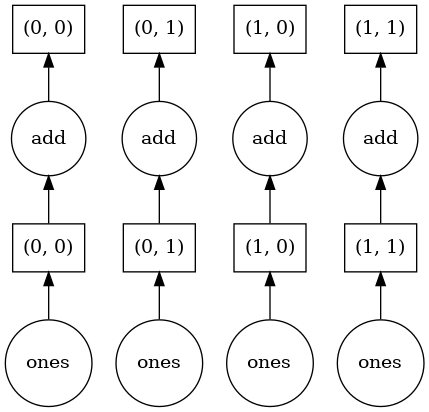

In [2]:
data = dask.array.ones((10,10), chunks=(5,5))

(data + 5).visualize()

In [3]:
(data + 5)[4,6].compute()

6.0

Since I've only asked for a single element of the array, only that one chunk needs to be calculated. This is less important for this tiny example, but it does get important when you've got a huge dataset that you only need a subset of.